In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from time import time
import useful_functions

In [2]:
import re

new_dir = os.path.join("C:/", "Shared", "Tesi magistrale", "databases")
stable_dir = os.path.join("C:/", "Shared", "Tesi magistrale", "databases", "stable")
dir_path = stable_dir
if(os.path.exists(dir_path) and os.path.isdir(dir_path)):
    print("Found!")
    files_names = [f for f in os.listdir(dir_path) 
                   if (os.path.isfile(os.path.join(dir_path, f)) and re.search(".csv$", f))]
    for f in files_names:
        print('\t%s' % f) #listdir returns a list of filenames

Found!
	VZZ_1618.csv
	VZZ_1618_TagAK4.csv
	VZZ_1618_TagAK8.csv
	ZZTo4l_2016.csv
	ZZTo4l_2016_TagAK4.csv
	ZZTo4l_2016_TagAK8.csv
	ZZTo4l_2017.csv
	ZZTo4l_2017_TagAK8.csv


In [3]:
def get_raw_data(file_path):
    try:
        in_file = open(file_path, 'r')  #TODO: Add an header row in the csv builder (DBGenerator.cc)
        raw_data = pd.read_csv(in_file, sep=',', engine='c', header=None) #raw_data is a pandas.DataFrame
    except IOError as e:
        print(e)
        return None
    else:
        in_file.close()
        return raw_data

In [4]:
def drawPoints(source, **kwargs):
    errTrain = [source[a]['train'] for a in source.keys()]
    errTest = [source[a]['test'] for a in source.keys()]
    print(source.keys())
    plt.title(kwargs.get("title", "Default Tittle"))
    plt.scatter(source.keys(), errTest, label='test')
    plt.scatter(source.keys(), errTrain, label='train')
    if(kwargs.get("logx", True)):
        plt.xlabel('log10(%s)' % kwargs.get("xlabel", "x axis"))
        plt.gca().set_xscale('log')
    else:
        plt.xlabel(kwargs.get("xlabel", "x axis"))
    plt.ylabel(kwargs.get("ylabel", "Error"))
    plt.legend()
    pass

In [5]:
from matplotlib.ticker import FormatStrFormatter

def grid_plot(data, nx, ny, **kwargs): #n_ = range of _
    scores = data.reshape(ny.shape[0], nx.shape[0])
    title = kwargs.get("title", "Title")
    
    if(kwargs.get("log", True)):
        scores = np.vectorize(lambda x: -math.log10(1-x))(scores)
        if(title!=""):
            title += " (-log(1-x))"
        #title.join(" (-log(1-x))")

    plt.figure(figsize=(8, 8))

    plt.imshow(scores, interpolation='nearest', origin='lower')#, cmap=plt.cm.hot)
    plt.title(title)
    #plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.3g'))
    #plt.gca().xaxis.set_minor_formatter(FormatStrFormatter('%.3g'))
    #plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3g'))
    #plt.gca().yaxis.set_minor_formatter(FormatStrFormatter('%.3g'))
    if(kwargs.get("logx", True)):
        plt.xlabel('log10(%s)' % kwargs.get("lx", "lx"))
        plt.xticks(np.arange(len(nx)), map(lambda x : round(math.log10(x),2), nx))
    else:
        plt.xlabel(kwargs.get("lx", "lx"))
        plt.xticks(np.arange(len(nx)), map(lambda x: round(x,2), nx))
    
    if(kwargs.get("logy", True)):
        plt.ylabel('log10(%s)' % kwargs.get("ly", "ly"))
        plt.yticks(np.arange(len(ny)), map(lambda x : round(math.log10(x),2), ny))  # math.log10(ny)
    else:
        plt.ylabel(kwargs.get("ly", "ly"))
        plt.yticks(np.arange(len(ny)), map(lambda x: round(x,3), ny))
    plt.colorbar()

In [6]:
def overf_log(grid):
    if(grid.cv_results_.get('mean_train_score') is None):
        print("Error: mean_train_score not found")
        return
    if(grid.cv_results_.get('mean_test_score') is None):
        print("Error: mean_test_score not found")
        return
    overfit = (grid.cv_results_['mean_train_score'] - grid.cv_results_['mean_test_score'])
    index = np.argmax(grid.cv_results_['mean_test_score'])
    print("Score at best params: %.2f %%" % (grid.cv_results_['mean_test_score'][index]*100))
    print("Overfit at best params = %.2f %%" % (overfit[index]*100))

# Data

In [7]:
data_sig = get_raw_data(os.path.join(dir_path, "VZZ_1618.csv"))
data_bkg = get_raw_data(os.path.join(dir_path, "ZZTo4l_2017.csv"))
print("Events total sig: %d \tevents total bkg: %d " % ( len(data_sig), len(data_bkg) ) )
print("Weight total sig: %.2f \tweight total bkg: %.2f " % ( sum(data_sig[1]), sum(data_bkg[1]) ) )

sig_SR = data_sig[data_sig[0] != 0].copy()
bkg_SR = data_bkg[data_bkg[0] != 0].copy()
print("Events sig SR: %d \tevents bkg SR: %d " % ( len(sig_SR), len(bkg_SR) ) )
print("Weight sig SR: %.2f \tweight bkg SR: %.2f " % ( sum(sig_SR[1]), sum(bkg_SR[1]) ) )
      #(sum(data_sig[1][data_sig[0] != 0]), sum(data_bkg[1][data_bkg[0] != 0])) )

#bkg_SR[0] = 0
#print("with target=1: %.2f \twith target=1: %.2f " % ( sum(sig_SR[1][sig_SR[0]!=0]), sum(bkg_SR[1][bkg_SR[0]!=0]) ) )
#print("shape:", sig_SR.shape,"  \tshape:", bkg_SR.shape)

del sig_SR, bkg_SR
#del data_bkg


Events total sig: 1854 	events total bkg: 13283 
Weight total sig: 8.22 	weight total bkg: 143.28 
Events sig SR: 962 	events bkg SR: 0 
Weight sig SR: 3.96 	weight bkg SR: 0.00 


In [8]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

assert (data_sig.shape[1] == data_bkg.shape[1]), "ERROR: Datasets have different shapes!"

# signal = everything
#data_sig[0] = 1

# signal = Search Region
data_raw = pd.concat([data_sig, data_bkg])

shuffle(data_raw, random_state=42)

data = data_raw[(data_raw[1] > 0)]

w_1r = sum(data_raw[data_raw[0] != 0][1])
w_0r = sum(data_raw[data_raw[0] == 0][1])
w_1 = sum(data[data[0] != 0][1])
w_0 = sum(data[data[0] == 0][1])

print("Signal events: %d \tweight: %.4g" % (len(data_raw[data_raw[0] != 0]), w_1r ) )
print("Backgr events: %d \tweight: %.4g" % (len(data_raw[data_raw[0] == 0]), w_0r ) )
print("\nStarting S/sqrt(B): %.3f\n" % (w_1r/math.sqrt(w_0r)) )
print("Trainable signal: %d \tweight: %.4g" % (len(data[data[0] != 0]), w_1 ) )
print("Trainable backgr: %d \tweight: %.4g" % (len(data[data[0] == 0]), w_0 ) )

del w_0r, w_1r

Signal events: 962 	weight: 3.964
Backgr events: 14175 	weight: 147.5

Starting S/sqrt(B): 0.326

Trainable signal: 890 	weight: 4.274
Trainable backgr: 14084 	weight: 148.1


In [9]:
# Separating features, weight and target

y_raw   = data_raw[0]
w_raw   = data_raw[1]
X_raw = data_raw.drop(0, axis=1).drop(1, axis=1)

y   = data[0]
w   = data[1]
X = data.drop(0, axis=1).drop(1, axis=1)
print("Features:", X.shape[1])

X_train, X_valid, w_train, w_valid, y_train, y_valid = train_test_split(X, w, y, test_size=0.2, random_state=42)

pass

Features: 26


Explained variance = 100.0 %
<class 'numpy.ndarray'> (14974, 7)


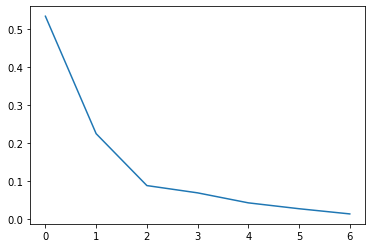

In [30]:
# Preprocessing: TruncatedSVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=7, n_iter=7, random_state=42)
X_red = svd.fit_transform(X)

plt.plot(svd.explained_variance_ratio_)
print("Explained variance = %.1f %%" % (100*svd.explained_variance_ratio_.sum()))
print(type(X_red), X_red.shape)

# Decision Tree

In [31]:
nTrees_Ada = np.logspace(1., 3., 7).astype(int)
lRate_Ada  = np.logspace(-1.5, -0.4, 7)
with np.printoptions(formatter={'float': lambda x: '%.3g' %(x)}):
    print("nTrees =", nTrees_Ada, "\t\t(", np.vectorize(lambda x: math.log10(x))(nTrees_Ada), ")")
    print("lRate =" , lRate_Ada , "\t(", np.vectorize(lambda x: math.log10(x))(lRate_Ada) , ")")

nTrees = [  10   21   46  100  215  464 1000] 		( [1 1.32 1.66 2 2.33 2.67 3] )
lRate = [0.0316 0.0482 0.0736 0.112 0.171 0.261 0.398] 	( [-1.5 -1.32 -1.13 -0.95 -0.767 -0.583 -0.4] )


In [35]:
X.isnull().values.any()

False

# AdaBoost

In [54]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

AdaBoost = AdaBoostClassifier(random_state=42)
nTrees_Ada = np.logspace(2.0, 3.5, 7).astype(int)
lRate_Ada  = np.logspace(-2.0, -1., 5)
with np.printoptions(formatter={'float': lambda x: '%.3g' %(x)}):
    print("nTrees =", nTrees_Ada, "\t\t(", np.vectorize(lambda x: math.log10(x))(nTrees_Ada), ")")
    print("lRate =" , lRate_Ada , "\t(", np.vectorize(lambda x: math.log10(x))(lRate_Ada) , ")")
    
grid_Ada = GridSearchCV(AdaBoost, param_grid={'n_estimators': nTrees_Ada, 'learning_rate': lRate_Ada}, 
                            verbose=10, scoring='roc_auc', cv=5, n_jobs=-1, return_train_score=True)

start = time()
grid_Ada.fit(X, y)#, fit_params={'sample_weight': w})
sec = time() - start
print("Elapsed time: %.0f s (%d\'%.d\")" % (sec, (int)(sec/60), int(sec)%60))
nTrees_best_Ada = grid_Ada.best_params_['n_estimators']
lRate_best_Ada  = grid_Ada.best_params_['learning_rate']
print ("best parameter choice: nTrees = %.2f (10^%.2f)" % (nTrees_best_Ada, math.log10(nTrees_best_Ada)))
print ("best parameter choice: lRate  = %.2f (10^%.2f)" % (lRate_best_Ada, math.log10(lRate_best_Ada)))

nTrees = [ 100  177  316  562 1000 1778 3162] 		( [2 2.25 2.5 2.75 3 3.25 3.5] )
lRate = [0.01 0.0178 0.0316 0.0562 0.1] 	( [-2 -1.75 -1.5 -1.25 -1] )
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed: 50

Elapsed time: 3123 s (52'2")
best parameter choice: nTrees = 1778.00 (10^3.25)
best parameter choice: lRate  = 0.01 (10^-2.00)


In [57]:
#AdaBoost.fit(X, y, sample_weight=w)

Best score = 0.806
Limit on lRate:  optimal may be lower


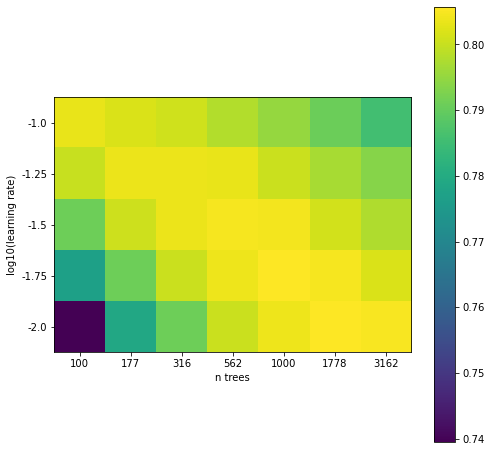

In [87]:
grid_plot(grid_Ada.cv_results_['mean_test_score'], nTrees_Ada, lRate_Ada, 
          lx="n trees", ly="learning rate", title="",#"AdaBoost - Score", 
          log=False, logx=False, logy=True)
print("Best score = %.3f" % (grid_Ada.best_score_))
if(nTrees_best_Ada==nTrees_Ada[0]):
    print("Limit on nTrees: optimal may be lower")
elif(nTrees_best_Ada==nTrees_Ada[-1]):
    print("Limit on nTrees: optimal may be higher")
if(lRate_best_Ada==lRate_Ada[0]):
    print("Limit on lRate:  optimal may be lower")
elif(lRate_best_Ada==lRate_Ada[-1]):
    print("Limit on lRate:  optimal may be higher")

Score at best params: 80.57 %
Overfit at best params = 2.85 %


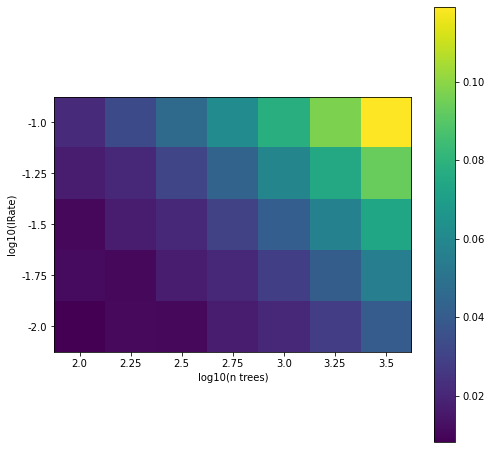

In [98]:
overfit = (grid_Ada.cv_results_['mean_train_score']-grid_Ada.cv_results_['mean_test_score'])
overf_log(grid_Ada)
grid_plot(overfit, nTrees_Ada, lRate_Ada, 
          lx="n trees", ly="lRate", title="",#"AdaBoost - Overfit", 
          logx=True, logy=True, log=False)

In [11]:
from sklearn.ensemble import AdaBoostClassifier

#Ada_VZZ = AdaBoostClassifier(n_estimators=nTrees_best_Ada, learning_rate=lRate_best_Ada, random_state=42)
Ada_VZZ = AdaBoostClassifier(n_estimators=1778, learning_rate=0.01, random_state=42)
print("n_estimators = %.d \tlearning_rate = %.3g" % (Ada_VZZ.n_estimators, Ada_VZZ.learning_rate))
start = time()
Ada_VZZ.fit(X_train, y_train)#, sample_weight=w_train)
print("Elapsed time: %.3g s" % (time()-start))

live_preds = Ada_VZZ.predict_proba(X_valid)[:, 1]

n_estimators = 1778 	learning_rate = 0.01
Elapsed time: 83.7 s


Area = 81.7%


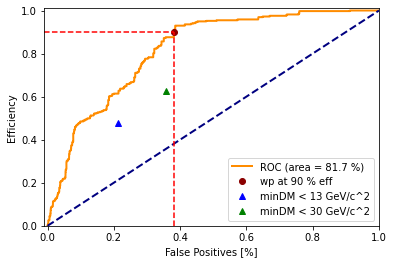

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_valid, live_preds, sample_weight=w_valid)
auc_testVZZ = auc(fpr, tpr)
print("Area = %.1f%%" % (100*auc_testVZZ))

eff = 0.90
wp_fpr = fpr[np.searchsorted(tpr, eff, side='right')]

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC (area = %.1f %%)' % (100*auc_testVZZ), linestyle='-')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot((wp_fpr), (eff), 'o', color='darkred', label='wp at %.0f %% eff' % (eff*100))
plt.plot((0.214019),(0.478722), "b^", label="minDM < 13 GeV/c^2")
plt.plot((0.356657),(0.624044), "g^", label="minDM < 30 GeV/c^2")
plt.plot((-0.01, wp_fpr),(eff, eff), "r--")
plt.plot((wp_fpr, wp_fpr),(0, eff), "r--")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positives [%]')
plt.ylabel('Efficiency')
#plt.title('ROC VZZ (Validation)')
plt.legend(loc="lower right")
pass

In [196]:
# Working point at 95% efficiency
i_wp = np.searchsorted(tpr, 0.95, side='right')
print("----- Working point at efficiency = 95 % -----")
print("Index: %i/%i" % (i_wp, len(thresholds)))
print('False positives: %.2f%% - threshold: %.3g' % (fpr[i_wp]*100, thresholds[i_wp]))
print("----- ----- ----- ----- ----- ----- ----- -----\n")

i_wp = np.searchsorted(tpr, 0.9, side='right')
print("----- Working point at efficiency = 90 % -----")
print("Index: %i/%i" % (i_wp, len(thresholds)))
print('False positives: %.2f %% - threshold: %.3g' % (fpr[i_wp]*100, thresholds[i_wp]))
print("----- ----- ----- ----- ----- ----- ----- -----")

----- Working point at efficiency = 95 % -----
Index: 1438/2851
False positives: 47.89% - threshold: 0.451
----- ----- ----- ----- ----- ----- ----- -----

----- Working point at efficiency = 90 % -----
Index: 1158/2851
False positives: 38.13 % - threshold: 0.458
----- ----- ----- ----- ----- ----- ----- -----


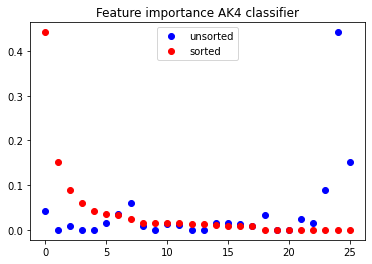

In [43]:
plt.plot(Ada_VZZ.feature_importances_[::-1], "bo", label='unsorted')
plt.plot(np.sort(Ada_VZZ.feature_importances_)[::-1], "ro", label='sorted')
plt.title("Feature importance AK4 classifier")
plt.legend()
pass

In [101]:
from pickle import Pickler

start=time()
Ada_VZZ.fit(X, y)#, sample_weight=w)
print("Training time = %.3g s" % (time() - start))
obj_path = os.path.join("C:/", "Shared", "VZZ_Evt_tree.pkl")

with open(obj_path, mode='w+b') as file: # "C:/Shared/VZZ_AK4_tree.pkl"
    pickler = Pickler(file)#, protocol=3)
    pickler.dump(Ada_VZZ)
    del pickler

size=os.stat(obj_path).st_size
j = math.floor(math.log(size,2)/10)
print("File size: %.3g %sB  (at %s)" % (size/1024**j, ['','K','M','G'][j], obj_path))
del size, j

Training time = 95.8 s
File size: 1.13 MB  (at C:/Shared\VZZ_Evt_tree.pkl)


In [102]:
from pickle import Unpickler

obj_path = os.path.join("C:/", "Shared", "VZZ_Evt_tree.pkl")
with open(obj_path, mode='rb') as file:
    unpickler = Unpickler(file)
    loaded_Ada_VZZ = unpickler.load()
    del unpickler

#print("Loaded Object ID: %d   Ada ID: %d   Same? %s" % (id(loaded_Ada_VZZ), id(Ada_VZZ), id(loaded_Ada_VZZ)==id(Ada_VZZ)))
print("Loaded Object ID:", id(loaded_Ada_VZZ))

Loaded Object ID: 1841147537800


In [104]:
loaded_pred = loaded_Ada_VZZ.predict_proba(X)[:,1]

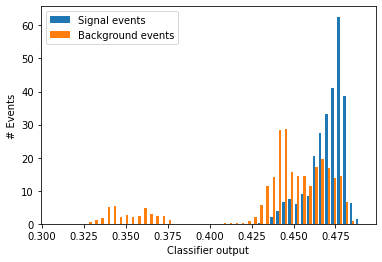

In [107]:
plt.hist([loaded_pred[y==1], loaded_pred[y==0]], 
         label=['Signal events', 'Background events'], bins=50, density=True)
plt.xlabel("Classifier output")
plt.ylabel("# Events")
plt.legend()
pass

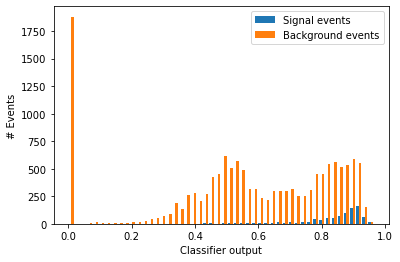

In [245]:
from scipy.special import erf
my_erf = lambda x,mean=loaded_pred.mean(),std=loaded_pred.std(): (erf((x-mean)/std) + 1)/2
spread_pred = np.vectorize(my_erf)(loaded_pred)

plt.hist([spread_pred[y==1], spread_pred[y==0]], 
         label=['Signal events', 'Background events'], bins=50)
plt.xlabel("Classifier output")
plt.ylabel("# Events")
plt.legend()
pass

In [225]:
print(live_preds.shape, w_valid.shape, y_valid.shape)
print(type(live_preds.shape), type(w_valid.shape), type(y_valid.shape))
temp = np.stack((np.array(y_valid), np.array(w_valid), np.array(live_preds)))
#dFvalid = pd.Dataframe()

(2995,) (2995,) (2995,)
<class 'tuple'> <class 'tuple'> <class 'tuple'>


In [234]:
#temp.transpose()[:5]
myDF = pd.DataFrame(temp.transpose())
myDF.to_csv("output.csv")

In [240]:
from scipy.special import erf
my_erf = lambda x,mean=live_preds.mean(),std=live_preds.std(): (erf((x-mean)/std) + 1)/2
live_spreaded_pred = np.vectorize(my_erf)(live_preds)

In [241]:
temp2 = np.stack((np.array(y_valid), np.array(w_valid), np.array(live_spreaded_pred)))
myDF2 = pd.DataFrame(temp.transpose())
myDF2.to_csv("transf.csv")

In [209]:
th90 = thresholds[i_wp]
print(th90)
true90 = np.searchsorted(np.sort(loaded_pred[y==1]), th90, side='right')
print(true90)
np.cumsum(np.sort(loaded_pred[y==1])[:true90])

0.4580456158716332
115


In [235]:
max(loaded_pred)

0.4902919438369451

In [202]:
loaded_pred

array([0.44393024, 0.43356417, 0.47649234, ..., 0.45930253, 0.43956384,
       0.46677721])

# Sig/sqrt(Bkg)

In [172]:
from scipy.special import erf
my_erf = lambda x,mean=loaded_pred.mean(),std=loaded_pred.std(): (erf((x-mean)/std) + 1)/2
spread_pred = np.vectorize(my_erf)(loaded_pred)

In [173]:
tmpS = np.stack((w[y==1].to_numpy(), spread_pred[y==1]))
sigDF = pd.DataFrame(tmpS) #.transpose()

tmpB = np.stack((w[y==0].to_numpy(), spread_pred[y==0]))
bkgDF = pd.DataFrame(tmp)

In [180]:
minim = min(spread_pred)
maxim = max(spread_pred)
bins = np.arange(minim, maxim,(maxim-minim)/99.5)
hist_sig = np.zeros(100)
hist_bkg = np.zeros(100)

for i,thr in enumerate(bins):
    for a in sigDF:
        if(sigDF[a][1] > thr):
            hist_sig[i] += sigDF[a][0]
    for a in bkgDF:
        if(bkgDF[a][1] > thr):
            hist_bkg[i] += bkgDF[a][0]

print(bins.shape, hist_sig.shape)

(100,) (100,)


In [217]:
totDF = pd.DataFrame(np.stack((y.to_numpy(), w.to_numpy(), spread_pred)).transpose())
totDF.head()
totDF.to_csv("here.csv")

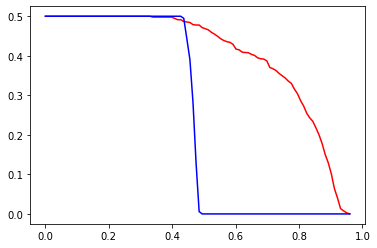

In [182]:
plt.plot(bins, hist_sig, "r-")
plt.plot(bins, hist_bkg, "b-")

In [194]:
significance = np.zeros(100)#map(lambda s,b: s/math.sqrt(b), (hist_sig, hist_bkg))
for i in range(99):
    significance[i] = hist_sig[i]/math.sqrt(hist_bkg[i])

C:\Users\Alberto\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


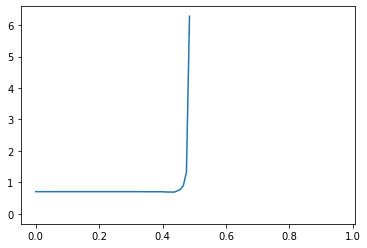

In [195]:
plt.plot(bins, significance)

In [185]:
significance = hist_sig/math.sqrt(hist_bkg)

TypeError: only size-1 arrays can be converted to Python scalars

# SVM

In [53]:
print("\n ----- ----- Support Vector Machine ----- ----- ")
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.decomposition import TruncatedSVD
from sklearn import svm


 ----- ----- Support Vector Machine ----- ----- 


## RBF kernel

In [54]:
gammas_RBF = np.logspace(-6.0, -5.0, 3)
Cs_RBF = np.logspace(3.5, 4.5, 3)
mySVM_rbf = svm.SVC(kernel='rbf')
grid_RBF = GridSearchCV(mySVM_rbf, param_grid={'gamma': gammas_RBF, 'C': Cs_RBF}, verbose=10, 
                            scoring='roc_auc', cv=5, n_jobs=-1, return_train_score=True)

start = time()
grid_RBF.fit(X_red, y)#, sample_weight=w)
print("Elapsed time: %.0f s" % (time() - start))
gammas_best_RBF = grid_RBF.best_params_['gamma']
Cs_best_RBF  = grid_RBF.best_params_['C']
print ("best parameter choice: gammas = %.2f (10^%.2f)" % (gammas_best_RBF, math.log10(gammas_best_RBF)))
print ("best parameter choice: Cs  = %.2f (10^%.2f)" % (Cs_best_RBF, math.log10(Cs_best_RBF)))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed: 20.7min remaining:   57.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 22.4min finished


Elapsed time: 1374 s
best parameter choice: gammas = 0.00 (10^-6.00)
best parameter choice: Cs  = 10000.00 (10^4.00)


Best score = 0.609


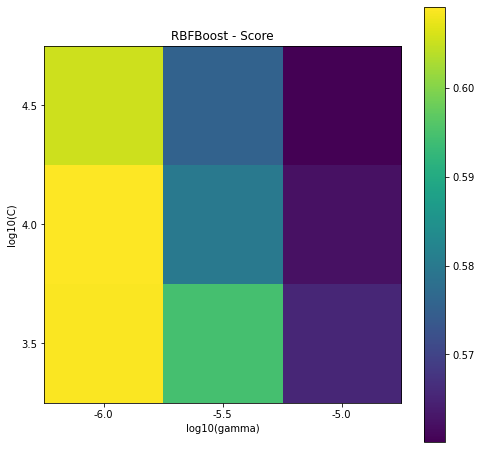

In [55]:
grid_plot(grid_RBF.cv_results_['mean_test_score'], gammas_RBF, Cs_RBF, 
          lx="gamma", ly="C", title="RBFBoost - Score", log=False, logx=True)
print("Best score = %.3f" % (grid_RBF.best_score_))

Score at best params: 0.609
Overfit at best params = 0.16


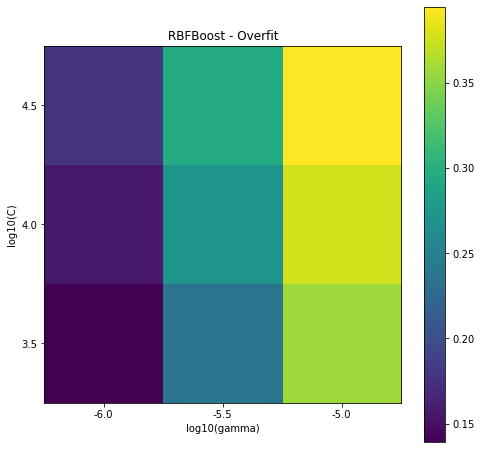

In [56]:
overfit = (grid_RBF.cv_results_['mean_train_score']-grid_RBF.cv_results_['mean_test_score'])
overf_log(grid_RBF)
grid_plot(overfit, gammas_RBF, Cs_RBF, title="RBFBoost - Overfit", lx="gamma", ly="C", 
          logx=True, log=False)

# Stuff

In [ ]:
#plt.hist(features8[3][target8==1], weights=weight8[target8==1], bins=50, range=(0.,120.)) #minDM
plt.hist(features8[3][target8==0], weights=weight8[target8==0], bins=50, range=(0.,120.))